In [1]:
import msprime
import numpy as np
from IPython.display import SVG
from matplotlib import pyplot as plt

(sec_randomness)=

# Randomness and replication

Simulations are used to generate random samples from complex distributions,
which we usually don't have analytical solutions for. In this section
we describe how msprime generates and
{ref}`controls randomness<sec_randomness_seeds>`, and
also how to efficiently and idiomatically run many
{ref}`replicate simulations<sec_randomness_replication>`
to summarise those distributions.

(sec_randomness_seeds)=

## Random seeds

Stochastic simulations depend on a source of randomness, provided by a
[psuedorandom number generator](<https://en.wikipedia.org/wiki/Pseudorandom_number_generator>).
Msprime uses the
[GNU Scientific Library](<https://www.gnu.org/software/gsl/doc/html/rng.html>)
to generate high-quality random numbers.
The particular trajectory produced by a pseudorandom number
generator is controlled by the "seed" it is provided.

:::{note}
By default, msprime generates random seeds using a private instance of
{class}`python:random.Random`, which should guarantee unique seeds are produced
even if (e.g.) many simulations are started at the same time in different
processes. In particular, simulations run concurrently in subprocesses using
{mod}`concurrent.futures` or {mod}`multiprocessing` will be assigned unique
seeds by default. See the {ref}`sec_randomness_replication_parallel` section
for more information and examples.
:::

Thus, if we run two {ref}`ancestry simulations<sec_ancestry>`
with the same parameters, we will get different results:

In [2]:
# Make this deterministic. DON'T DO THIS IN YOUR CODE.
msprime.core.set_seed_rng_seed(412)

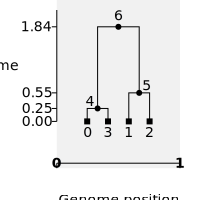

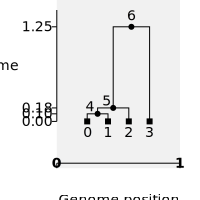

In [3]:
from IPython.display import display, SVG

ts1 = msprime.sim_ancestry(2)
ts2 = msprime.sim_ancestry(2)
display(SVG(ts1.draw_svg(y_axis=True)), SVG(ts2.draw_svg(y_axis=True)))

The `random_seed` argument to {func}`.sim_ancestry` allows us specify
seeds explicitly, making the output of the simulation fully deterministic:

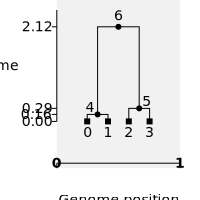

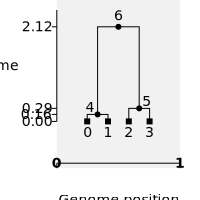

In [4]:
ts1 = msprime.sim_ancestry(2, random_seed=42)
ts2 = msprime.sim_ancestry(2, random_seed=42)
display(SVG(ts1.draw_svg(y_axis=True)), SVG(ts2.draw_svg(y_axis=True)))

Similarly, if we run two different {ref}`mutation simulations<sec_mutations>`
on the same ancestry, we'll get different sets of mutations (and, therefore,
genome sequences):

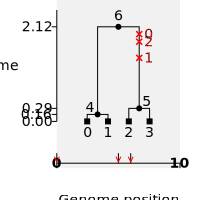

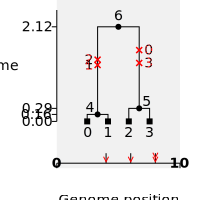

In [5]:
ts = msprime.sim_ancestry(2, sequence_length=10, random_seed=42)
mts1 = msprime.sim_mutations(ts, rate=0.1)
mts2 = msprime.sim_mutations(ts, rate=0.1)
display(SVG(mts1.draw_svg(y_axis=True)), SVG(mts2.draw_svg(y_axis=True)))

We can see that mutations occur at different positions along the genome,
and also on different branches of the trees. If we provide
the ``random_seed`` argument to {func}`.sim_mutations`, we will get
precisely the same result in both simulations:

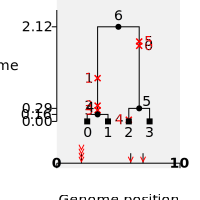

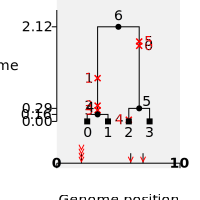

In [6]:
ts = msprime.sim_ancestry(2, sequence_length=10, random_seed=42)
mts1 = msprime.sim_mutations(ts, rate=0.1, random_seed=666)
mts2 = msprime.sim_mutations(ts, rate=0.1, random_seed=666)
display(SVG(mts1.draw_svg(y_axis=True)), SVG(mts2.draw_svg(y_axis=True)))

(sec_randomness_replication)=

## Running replicate simulations

Simulations are random, and we will therefore usually want to have
many independent replicates for a particular set of parameters. In
this section we provide some examples of how to efficiently
run replicate simulations in msprime.

### Ancestry simulations

When performing {ref}`ancestry simulations<sec_ancestry>` with
{func}`.sim_ancestry`, the `num_replicates` parameter provides a
convenient and efficient
way to iterate over a number of replicate simulations. For example,
suppose we wish to examine the distribution of the
time to the most recent common ancestor.

In [7]:
import numpy as np

num_replicates = 100
tmrca = np.zeros(num_replicates)
replicates = msprime.sim_ancestry(10, num_replicates=num_replicates, random_seed=42)
for replicate_index, ts in enumerate(replicates):
    tree = ts.first()
    tmrca[replicate_index] = tree.time(tree.root)
np.mean(tmrca), np.var(tmrca)

(3.799291711240622, 3.920289255957004)

:::{tip}
Using the ``num_replicates`` argument like this can be substantially
more efficient that running simulations independently for
small simulations.
:::

It's important to note that the replicate simulations are generated
lazily here on demand---the `replicates` variable is a Python iterator,
and we use the built-in {func}`python:enumerate` function to easily get
the index of each replicate in the list. Thus, no simulation
is actually done when we call ``sim_ancestry`` here, it's just setting
up the underlying state. Each replicate simulation is done sequentially
as we go through the loop. We therefore only use the memory that
we need to represent the results of *one* simulation.

:::{warning}
It's a bad idea to store the result of ``sim_ancestry`` in a list like
this:

```
replicates = list(msprime.sim_ancestry(10, num_replicates=100))
```

Unlike the efficient example above, this will run all 100 simulations
before returning and store the resulting tree sequences in memory.
This consumes approximately 100X more memory that the example above!
:::

:::{note}
The return type of {func}`.sim_ancestry` changes when we use the
`num_replicates` argument. If `num_replicates` is not specified
or `None`, we return an instance of {class}`tskit.TreeSequence`.
If it is specified, we return an *iterator* over
a set of {class}`tskit.TreeSequence` instances.
:::

(sec_randomness_replication_mutations)=

### Adding mutations

Things are a little more involved when we also want to simulate
mutations on the simulated ancestries, because we cannot get a
stream of replicate results directly from {func}`.sim_ancestry`.
In this section we a number of different and idiomatic ways to
efficiently combine ancestry and mutation simulations.

:::{seealso}
It is often assumed that mutations are a necessary part of simulating
population genetic processes, but this is often not the case.
See the {ref}`tutorial<tutorials:sec_tskit_no_mutations>` on this
topic for more information.
:::

#### Using a generator

In this example we define a
["generator"](https://docs.python.org/3/tutorial/classes.html#generators)
function that runs a set of replicate ancestry simulations,
simulates mutations on them, and sequentially yields
the resulting tree sequence to the calling code:

In [8]:
def sim_replicates(sample_size, num_replicates):
    ancestry_reps = msprime.sim_ancestry(
        samples=sample_size,
        population_size=100, sequence_length=1_000,
        num_replicates=num_replicates)
    for ts in ancestry_reps:
        mutated_ts = msprime.sim_mutations(ts, rate=1e-6)
        yield mutated_ts

In general it's a good idea to encapsulate specific simulations
in a function like this: an free parameters (like ``sample_size`` here)
can be passed in as parameters to the function, and any fixed values
(like e.g., ``sequence_length``) can be specified in one place,
avoiding repetition and potential for mistakes. Having defined the
generator function, we can now run it for a given number of
replicates and sample size. In this example, we com
compute the number of
{meth}`segregating sites<tskit:tskit.TreeSequence.segregating_sites>`
in each replicate tree sequence, and store the values in a numpy
array:

In [9]:
num_replicates = 100
S = np.zeros(num_replicates)
for replicate_index, ts in enumerate(sim_replicates(10, num_replicates)):
    S[replicate_index] = ts.segregating_sites(span_normalise=False, mode="site")
# Show the mean and variance of S
(np.mean(S), np.var(S))

(1.52, 1.5495999999999999)

Again, this approach means that we only have the tree sequence for
one replicate simulation in memory at one time.

#### Using functional tools

Another way in which we can efficiently apply mutations to replicate
simulations is using Python's functional programming tools:

In [10]:
import functools

num_replicates = 100
S = np.zeros(num_replicates)
ancestry_reps = msprime.sim_ancestry(
    samples=10,
    population_size=100,
    sequence_length=1_000,
    num_replicates=num_replicates)
mutations_func = functools.partial(msprime.sim_mutations, rate=1e-6)
mutations_reps = map(mutations_func, ancestry_reps)

for replicate_index, ts in enumerate(mutations_reps):
    S[replicate_index] = ts.segregating_sites(span_normalise=False, mode="site")
(np.mean(S), np.var(S))

(1.47, 2.0691)

In this example we use Python's {func}`python:map` function to iteratively
apply the {func}`.sim_mutations` function to the output of
{func}`.sim_ancestry`. Because ``map`` only expects a single argument
and we also need to specify the ``rate`` value,
we need to create a "partial" function which sets the mutation rate
(and any other parameters we might like to provide) for {func}`.sim_mutations`.
This could equally be done using a
[lambda expression](https://docs.python.org/3/tutorial/controlflow.html#lambda-expressions)
or indeed by defining a function in the usual way using ``def``.

:::{warning}
Do not set the random seed to a fixed value in partial function like
this! This would result in different random ancestry replicates
being correctly generated but all mutations being thrown down
using the same seed. This would lead to nasty bugs!
:::

(sec_randomness_replication_specifying_seeds)=

### Specifying seeds explicitly

When we're running large simulations it's usually better to specify the
seeds explicitly and run ancestry simulations individually. First
we define a function that takes our free parameters (``num_samples``
in this case) and random seed values for the ancestry and
mutation simulations:

In [11]:
def run_sim(num_samples, ancestry_seed, mutation_seed):
    ancestry_ts = msprime.sim_ancestry(
        samples=num_samples,
        population_size=100,
        sequence_length=1_000,
        random_seed=ancestry_seed)
    mutated_ts = msprime.sim_mutations(
        ancestry_ts, rate=1e-6, random_seed=mutation_seed)
    return mutated_ts

:::{note}
Note that this function is not a generator---it returns a *single*
tree sequence, rather than an iterator over replicate tree sequences.
:::

Having defined this function, we can then generate some random
seeds using numpy (note that we seed the random generator
to make the seeds themselves deterministic---otherwise,
we might as well let msprime generate random seeds):

In [12]:
num_replicates = 100
rng = np.random.RandomState(42)
seeds = rng.randint(1, 2**31, size=(num_replicates, 2))

S = np.zeros(num_replicates)
for replicate_index in range(num_replicates):
    ts = run_sim(10, *seeds[replicate_index])
    S[replicate_index] = ts.segregating_sites(span_normalise=False, mode="site")

(np.mean(S), np.var(S))

(1.28, 1.1016)

(sec_randomness_replication_parallel)=

### Running in parallel

When we are running replicates of large simulations we will usually
want to take advantage of the available CPU cores and run them
in parallel. Since replicates are independent, this is quite easy
to do using Python's {mod}`python:concurrent.futures` module.

When running simulations in parallel it's important to create a
simple function that runs your simulation in the worker processes.
First we define this function:

In [13]:
import concurrent.futures

def worker(seeds):
    ancestry_seed, mutation_seed = seeds
    ts = msprime.sim_ancestry(
        samples=10,
        population_size=100,
        sequence_length=1_000,
        random_seed=ancestry_seed)
    ts = msprime.sim_mutations(ts, rate=1e-6, random_seed=mutation_seed)
    return ts.segregating_sites(span_normalise=False, mode="site")

Note that this is almost the same as the function we defined
in the {ref}`sec_randomness_replication_specifying_seeds` section,
with a few differences:

1. The ``worker`` function takes one parameter, ``seeds``, which
we unpack manually into the ``ancestry_seed`` and ``mutation_seed``.
2. We have no free parameters, as it is much simpler to fully
specify the worker function than it is to use partial functions in the
context of multiple processes.
3. We return the final result that we are interested (the segregating
sites value) in rather than the simulated tree sequence. There
are two good reasons for this: (a) we want to do as much computation
as we can in the worker process and as little as possible in the
main process; and (b) we want to keep the values that we return
from the worker process as small and simple as we can to
avoid serialisation overhead.

Once we've defined the function, then we can generate some
random seeds as before, and then use the
``map`` method of {class}`~python:concurrent.futures.ProcessPoolExecutor`
to distribute the work among all available CPU cores:

In [14]:
num_replicates = 100
rng = np.random.RandomState(42)
seeds = rng.randint(1, 2**31, size=(num_replicates, 2))

with concurrent.futures.ProcessPoolExecutor() as executor:
    results = executor.map(worker, seeds)
    S = np.array(list(results))

(np.mean(S), np.var(S))

(1.28, 1.1016)

:::{note}
This approach is a good pattern to use when running replicates
of large simulations, requiring at least (say) 10 seconds to run.
It will not be efficient as a way of running large numbers of
small simulations, though.
:::